   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Headset Microphone (2- Astro A5, MME (2 in, 0 out)
   2 Microphone (USB Audio Device ), MME (2 in, 0 out)
   3 Headset Microphone (Oculus Virt, MME (2 in, 0 out)
   4 Microphone (Iriun Webcam), MME (2 in, 0 out)
   5 Line (2- Astro A50 Game), MME (2 in, 0 out)
   6 Microphone (Logi C270 HD WebCam, MME (2 in, 0 out)
   7 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  8 Headphones (2- Astro A50 Game), MME (0 in, 2 out)
   9 Headphones (Oculus Virtual Audi, MME (0 in, 2 out)
  10 Digital Audio (S/PDIF) (High De, MME (0 in, 2 out)
  11 ZOWIE XL LCD (NVIDIA High Defin, MME (0 in, 2 out)
  12 Headset Earphone (2- Astro A50 , MME (0 in, 2 out)
  13 Speakers (USB Audio Device ), MME (0 in, 2 out)
  14 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
  15 Headset Microphone (2- Astro A50 Voice), Windows DirectSound (2 in, 0 out)
  16 Microphone (USB Audio Device ), Windows DirectSound (2 in, 0 out)
  17 Headset Mi

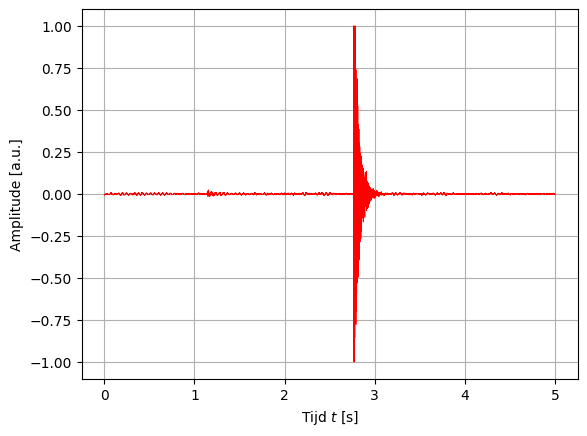

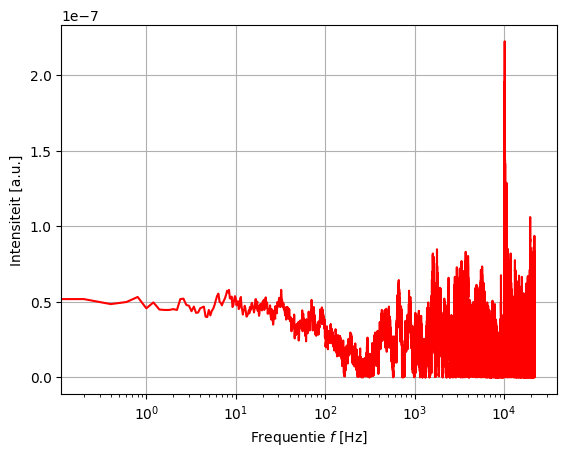

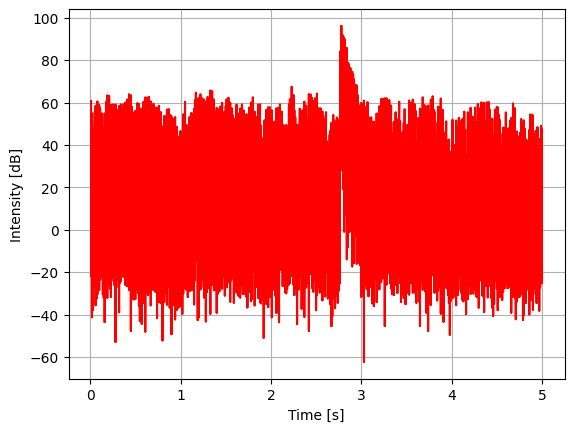

max:96.1216198022071


In [117]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
from mijngeluid import fft_partitioned # zet mijngeluid.py in dezelfde folder als je notebook
import math
#import pandas as pd

def debug_sound_devices():
    print(sd.query_devices()) # geeft een lijst met devices en de bijbehorende nummers

def record(duration_in_seconds):
    fs = 44100 # sample rate, zie microfoon specificaties
    duration = duration_in_seconds # in seconden
    _arr = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64', device=16) # neemt op in de achtergrond
    sd.wait() # returns wanneer sd.rec() klaar is
    return _arr, duration, fs

def plot_amplitude_against_time(_duration, _fs):
    t = np.linspace(0, _duration, int(_fs*_duration)) # maak (voor het gemak) een tijd as
    plt.figure(dpi=100)
    plt.plot(t, arr, 'r-', ms=0.5, lw=0.5)
    plt.grid()
    plt.xlabel(r"Tijd $t$ [s]")
    plt.ylabel(r"Amplitude [a.u.]") # arbitrary units (we hebben niets gekalibreerd)

def transform_fast_fourier(_duration, _sample_rate):
    _sample_amount = int(_sample_rate*_duration) # Nsamples in signaal
    _period = _duration/_sample_amount # Sampling tijd (trillingstijd)

    fhat = np.fft.fft(arr)
    _frequency = np.linspace(0.0, 1.0/(2.0*_period), _sample_amount//2) # frequentie
    _intensity = 2.0/_sample_amount * np.abs(fhat[:_sample_amount//2]) # Intensteit ||.||^2

    return _frequency, _intensity, _period



def plot_intensity_against_frequency(_frequency, _intensity):
    plt.figure(dpi=100)
    plt.plot(_frequency, _intensity, 'r-')
    plt.grid()
    #plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"Frequentie $f$ [Hz]")
    plt.ylabel(r"Intensiteit [a.u.]")

def partition_with_time(_arr, _sample_rate, _duration):
    return fft_partitioned(_arr, _sample_rate, _duration, t_bin=1e-2) # t_bin is de bin grootte in seconden

def calculate_decibels(_intensity_array, _intensity_offset, _decibel_offset):
    # return 10*np.log10(_intensity_array)
    y2 = _intensity_array.tolist()

    y2 = np.array(y2)
    y2[y2==0]=1e-12

    y3 = y2.tolist()
    y4 = []
    for I in y3:
        y4.append((10*(math.log(I/_intensity_offset))) + _decibel_offset)
    return y4

def plot_decibel_against_time(_time_stamps, _decibel_array):
    plt.figure(dpi=100)
    plt.plot(_time_stamps, _decibel_array, 'r-') # plot dB against time
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel("Intensity [dB]")
    plt.show()

debug_sound_devices()

# Step 1 record
arr, duration, sample_rate = record(5)
# Debug amplitude against time
plot_amplitude_against_time(_duration=duration, _fs=sample_rate)

# Step 2: Fast Fourier Transformatie
frequency, intensity_array, period = transform_fast_fourier(duration, sample_rate)
# Debug intensity against frequency
plot_intensity_against_frequency(frequency, intensity_array)

# Step 3: Partition with time
# TODO What is arr[:,0]?
df = partition_with_time(arr[:,0], sample_rate, duration)
print(df)
decibel_array = calculate_decibels(df.I, 1, 108)
plot_decibel_against_time(df.t, decibel_array)

print("max:" + str(np.amax(decibel_array)))


In [119]:
def get_reverb_time(_time_stamps, _decibel_array):
    # Find the maximum sound level in the decibel array
    max_sound_level = np.max(_decibel_array)

    # Find the index of the maximum sound level in the decibel array
    max_sound_level_index = np.argmax(_decibel_array)

    # Find the index of the first data point where the sound level is 60 dB below the maximum sound level
    decay_point_index = np.argmax((_decibel_array <= max_sound_level - 60) & (_time_stamps > _time_stamps[max_sound_level_index]))

    # Calculate the time it takes for the sound level to decay by 60 dB
    reverb_time = _time_stamps[decay_point_index] - _time_stamps[max_sound_level_index]

    return reverb_time

print("reverbation time: ")
print(str(get_reverb_time(np.array(df.t), decibel_array)))

reverbation time: 
0.009999999999999787
